In [1]:
import pandas as pd
import numpy as np
import pymysql
from sqlalchemy import create_engine
import re
import os
from functools import reduce
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import math
import matplotlib.pyplot as plt
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

### Loading Data From Database(MySQL)

In [3]:
username = 'yuting'
password = pwd
host_port = host_port
database = 'twfruits'

engine = create_engine("mysql+pymysql://{}:{}@{}/{}".format(username, password, host_port, database))
con = engine.connect()

In [4]:
df = pd.read_sql('marketing_price_emperorguava', engine)
df.head()

,日期,市場,產品,上價,中價,下價,平均價(元/公斤),交易量(公斤)
0,100/01/07,104 台北二,P3 番石榴 帝王芭,28.0,26.1,20.0,25.3,48
1,100/01/08,104 台北二,P3 番石榴 帝王芭,41.0,30.9,18.0,30.4,56
2,100/01/14,104 台北二,P3 番石榴 帝王芭,20.0,20.0,20.0,20.0,33
3,100/01/15,104 台北二,P3 番石榴 帝王芭,25.0,25.0,25.0,25.0,40
4,100/01/18,104 台北二,P3 番石榴 帝王芭,31.4,21.3,12.0,21.4,66


#### Data Cleaning

In [7]:
from my_libs.data_cleaner import df_cleaner, df_merger

In [5]:
fruits = {"banana": ["banana", "scarletbanana", "guava"],
          "guava":  ["guava", 'emperorguava', 'banana']}
n = "guava"
markets = ['台北二', '台北一', '三重區', '台中市']

df = df_cleaner(pd.read_sql(f'marketing_price_{fruits[n][0]}', engine))
df_same = df_cleaner(pd.read_sql(f'marketing_price_{fruits[n][1]}', engine))
df_sub = df_cleaner(pd.read_sql(f'marketing_price_{fruits[n][2]}', engine))


In [6]:
df_merger(df, df_same, df_sub, fruits["banana"], market='台中市')

,日期,banana_平均價,banana_交易量,scarletbanana_平均價,guava_平均價,banana_前日平均價,banana_5日平均價
0,2011-01-01,33.7,18212.0,47.7,22.1,33.7,35.5
1,2011-01-02,36.1,22148.0,44.2,21.7,33.7,35.5
2,2011-01-03,36.1,22307.5,59.6,23.3,36.1,35.5
3,2011-01-04,36.1,22467.0,75.0,24.9,36.1,35.5
4,2011-01-05,35.6,17132.0,54.5,23.6,36.1,35.5
...,...,...,...,...,...,...,...
3866,2021-08-02,17.8,23704.0,30.9,30.5,17.7,18.8
3867,2021-08-03,17.8,32079.0,33.9,30.3,17.8,18.4
3868,2021-08-04,19.7,24201.0,32.1,30.9,17.8,18.1
3869,2021-08-05,18.1,42196.0,36.2,31.8,19.7,18.2


### 訓練集&測試集

In [5]:
def train_test_split(df):
    test_samples = int(df.shape[0]*0.2)
    
    # 訓練集
    train_data = df.iloc[:-test_samples, :]
    train_set = train_data.iloc[:, 1:].values           # 取得train_set(array)
 
    
    # 測試集
    test_data = df.iloc[-test_samples:, :]
    test_set = test_data.iloc[:, 1:].values             # 取得test_set(array)
       
    return train_set, test_set

### data normalization

In [7]:
def data_normalization(input_set):
    
    # 訓練集(scaler)
    sc = StandardScaler()
    input_set_sc = sc.fit_transform(input_set[:, :])

    sc_target = StandardScaler()
    sc_target.fit_transform(input_set[:, 0:1])
    
    return input_set_sc, sc_target

#### 創造X、Y資料

In [8]:
def split_Xy(input_set_sc, n_future, n_past):
    X = []
    y = []

    for i in range(n_past, len(input_set_sc)-n_future+1): # 扣掉最後預測天數已符合y_test的length 
        X.append(input_set_sc[i-n_past:i, 1:])       # 利用前30天資料來預測後7天價格，            ###特徵值排除banana價格本身
        y.append(input_set_sc[i:i+n_future, 0])      # 後7天價格

    X, y = np.array(X), np.array(y) 
    
    print("X's shape: {}".format(X.shape))
    print("y's shape: {}".format(y.shape))
    
    return X, y

### model biluder

In [20]:
def model_creator(n_steps, n_features, output):
    model = Sequential()
    
    # 1st layer 
    # input_shape => n_step, n_feature 


    model.add(LSTM(units=64, activation="relu", input_shape=(n_steps, n_features)))#, return_sequences=True)) 

    #model.add(LSTM(units=32, activation="relu", return_sequences=False))          

    #model.add(Dropout(0.2))

    model.add(Dense(output))          

    model.summary() 
     
    return model

### model trainer

In [10]:
def model_trainer(model, X_train, y_train, epoch, batch_size):
    
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    # 提升訓練效率
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    
    history = model.fit(X_train, y_train, epochs=epoch, 
                        batch_size=batch_size,
                        callbacks=[es, rlr, mcp], 
                        validation_split=0.1,
                        shuffle=False,
                        verbose=1)
    # 視覺化
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    
    return model

### 驗證model準確率

In [11]:
def model_validation(model, X, y, sc_target):
    
    # 預測
    prediction = model.predict(X)
    prediction = sc_target.inverse_transform(prediction)
    actual = sc_target.inverse_transform(y)
    
    rmse_result = []
    for i in range(len(prediction)):
        rmse = mean_squared_error(prediction[i], actual[i], squared=False)
        rmse_result.append(rmse)

    pd.DataFrame({"rmse":rmse_result}).plot()
    
    return prediction, actual

X's shape: (3080, 3, 5)
y's shape: (3080, 15)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_3 (Dense)              (None, 15)                975       
Total params: 18,895
Trainable params: 18,895
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
22/22 [==============================] - 2s 14ms/step - loss: 0.9956 - val_loss: 0.1593

Epoch 00001: val_loss improved from inf to 0.15935, saving model to weights.h5
Epoch 2/12
22/22 [==============================] - 0s 5ms/step - loss: 0.8373 - val_loss: 0.1230

Epoch 00002: val_loss improved from 0.15935 to 0.12303, saving model to weights.h5
Epoch 3/12
22/22 [==============================] - 0s 5ms/step - loss: 0.6035 - val_loss: 0.0770

Epoch 

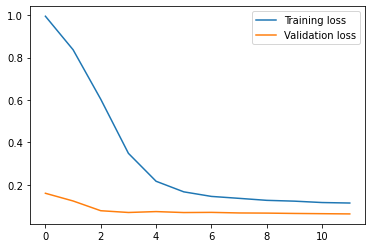

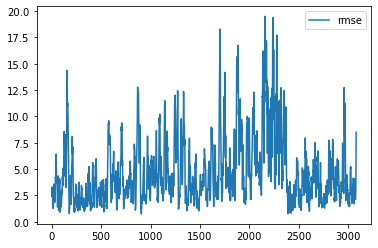

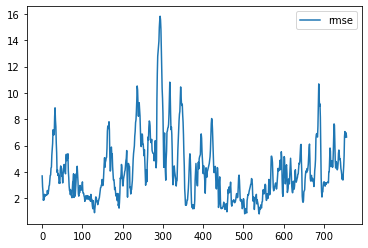

In [21]:
Type = "banana"
market = "台北二"

n_future = 
n_past = 


# 讀取分析資料
df = pd.read_sql(f"{Type}_{market}", engine)

# 訓練集、測試集
train_set, test_set = train_test_split(df)

### 訓練集part
# 訓練集(sc)、訓練集預測(scaler)
train_set_sc, sc_train_target = data_normalization(train_set)

# 訓練集
X_train, y_train = split_Xy(train_set_sc, n_future=15, n_past=3)

# 創造momdel
model = model_creator(n_past=X_train.shape[1], n_features=X_train.shape[2], output=y_train.shape[1])

# 訓練model
trained_model = model_trainer(model, X_train, y_train, epoch=12, batch_size=128)

# 訓練集驗證
prediction_train, actual_train = model_validation(trained_model, X_train, y_train, sc_train_target)

### 測試集part
# 測試集(sc)、測試集預測(scaler)
test_set_sc, sc_test_target = data_normalization(test_set)

# 測試集、test_scaler
X_test, y_test = split_Xy(test_set_sc, n_future=15, n_past=3)

# 測試集驗證
prediction_test, actual_test = model_validation(trained_model, X_test, y_test, sc_test_target)


In [22]:
print(prediction_test[-1])
print(actual_test[-1])

[31.178009 30.748245 30.379797 31.049479 31.248592 30.127357 30.043394
 30.870543 31.007965 31.158302 29.734823 29.706379 29.63619  30.553246
 30.350584]
[31.8 29.5 34.4 33.6 32.8 34.3 41.2 37.3 37.6 40.2 37.7 35.2 37.9 40.7
 38.3]


### 從SQL取資料進行模型訓練 => 完成後存成h5檔(共8個)
- 儲存訓練完成的model

In [ ]:
fruits = {"banana": ["banana", "scarletbanana", "guava"],
          "guava":  ["guava", 'emperorguava', 'banana']}

markets = ['台北二', '台北一', '三重區', '台中市']


for Type, fruit in fruits.items():
    for market in markets:
    
        # 讀取分析資料
        df = pd.read_sql(f"{Type}_{market}", engine)
    
        # 訓練集、測試集
        train_set, test_set = train_test_split(df)

        ### 訓練集part
        # 訓練集(sc)、訓練集預測(scaler)
        train_set_sc, sc_train_target = data_normalization(train_set)

        # 訓練集
        X_train, y_train = split_Xy(train_set_sc, n_future=5, n_past=30)

        # 創造momdel
        model = model_creator(n_steps=X_train.shape[1], n_features=X_train.shape[2])

        # 訓練model
        trained_model = model_trainer(model, X_train, y_train, epoch=12, batch_size=128)

        # 訓練集驗證
        prediction_train, actual_train = model_validation(trained_model, X_train, y_train, sc_train_target)

        ### 測試集part
        # 測試集(sc)、測試集預測(scaler)
        test_set_sc, sc_test_target = data_normalization(test_set)

        # 測試集、test_scaler
        X_test, y_test = split_Xy(test_set_sc, n_future=5, n_past=30)

        # 測試集驗證
        prediction_test, actual_test = model_validation(trained_model, X_test, y_test, sc_test_target)
        
        # 儲存模型
        # model.save(f"C:/Users/Tibame/PycharmProjects/PythonETL/Fruit Price Prediction/models/{Type}_Price/{market}.h5")
        
        

### 從SQL取資料進行價格預測
- 稍待DB那邊資料清洗合併後存入，直接SQL語句取值進行分析
- 預測結果存入DB

In [ ]:
fruits = {"banana": ["banana", "scarletbanana", "guava"],
          "guava":  ["guava", 'emperorguava', 'banana']}

markets = ['台北二', '台北一', '三重區', '台中市']


for Fruit, Type in fruits.items():
    for market in markets:
        
        product = Type[0]
        same = Type[1]
        sub = Type[2]
        
        # 從SQL讀取分析資料，轉換成矩陣
        df_set = pd.read_sql_query(f"""select `{product}_平均價`, `{product}_交易量`, `{same}_平均價`, 
                                       `{sub}_平均價`, `{product}_前日平均價`, `{product}_5日平均價` 
                                       from {product}_{market}
                                       order by `日期` desc
                                       limit 30""", con).values 
        
        # 標準化
        df_set_sc, sc_target = data_normalization(df_set)
        
        # reshape => 需符合input的shape
        df_set_sc = df_set_sc.reshape(-1, 30, 6)
        
        # 載入model
        model_loaded = keras.models.load_model(f"models/{product}_Price/{market}.h5")
        
        # 進行預測
        pred_result = model_loaded(df_set_sc) # 使用model_loaded.predict(df_set_sc)會跳出tensorflow wwarning
        
        # 透過inverse_transform還原為原本數值
        output = sc_target.inverse_transform(pred_result)
        
        print(f"{Fruit}_{market}市場未來7日預測價: ", output.reshape(-1).round(1))
